<a href="https://colab.research.google.com/github/Rajnandini17/Deep-Learning-projects/blob/main/Face_Expression_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTING THE DATASET

In [1]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2023-09-27 17:11:48--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2023-09-27 17:11:49--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc024ef1e57bc27c8e803a80a165.dl.dropboxusercontent.com/cd/0/inline/CEhmXh9X0m3NSsROshddKGDwOwwpKjp9Bt7lVwcWbc2zXxPkpvpKGYU_IQeKJhC3VL6HZeDtXfnrDfxJ3bHmdiAjqdKg-tViSn_LC4tqR1m435Ja1eLbCxIVvyEiwcEsYqSWyDHNrUgxcRubm0H-cQ6m/file# [following]
--2023-09-27 17:11:52--  https://uc024ef1e57bc27c8e803a80a165.dl.dropboxusercontent.com/cd/0/inline/CEhmXh9X0m3NSsROshddKGDwOwwpKjp9Bt7lVwcWbc2zXxPkpvpKGYU_IQeKJhC3VL6HZeDtXfnrDfxJ3bHmdiAjqdKg-tViSn_LC4tqR

In [2]:
!unzip -q "/content/archive.zip"

##IMPORTING LIBRARIES & PROCESSING IMAGES

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [4]:
train_path = Path("/content/train")
test_path = Path("/content/test")

In [5]:
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x), train_image_paths))
train_image_paths[:10]

['/content/train/angry/Training_86750647.jpg',
 '/content/train/angry/Training_37648612.jpg',
 '/content/train/angry/Training_93477899.jpg',
 '/content/train/angry/Training_91019189.jpg',
 '/content/train/angry/Training_1184435.jpg',
 '/content/train/angry/Training_16813100.jpg',
 '/content/train/angry/Training_83505715.jpg',
 '/content/train/angry/Training_93430422.jpg',
 '/content/train/angry/Training_31734020.jpg',
 '/content/train/angry/Training_67213645.jpg']

In [6]:
def get_label(image_path):
  return image_path.split("/")[-2]

train_image_labels = list(map(lambda x: get_label(x), train_image_paths))
train_image_labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

In [7]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)
train_image_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)
train_image_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths, train_image_labels, test_size=0.25)

In [10]:
#computing class weights to take care of class imbalances
classTotals = train_labels.sum(axis = 0)
classWeight = classTotals.max() / classTotals
class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8228571, 1: 16.091988, 2: 1.7499193, 3: 1.0, 4: 1.4476775, 5: 1.5068074, 6: 2.3056972}


## LOADING & AUGMENTING IMAGE DATA

In [11]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [12]:
# Define IMAGE SIZE and BATCH SIZE
IMG_SIZE = 96
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [13]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

In [15]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 869 ms, sys: 8.23 ms, total: 878 ms
Wall time: 932 ms
(32, 96, 96, 3)
(32, 7)


fear


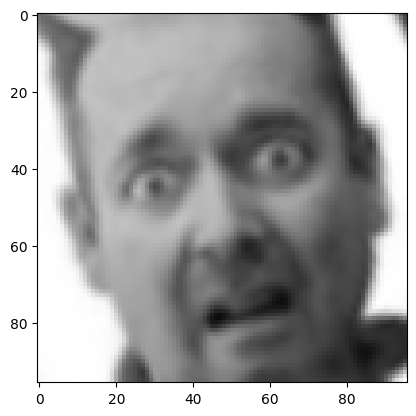

In [18]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [19]:
%time val_dataset = get_dataset(val_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 38.8 ms, sys: 0 ns, total: 38.8 ms
Wall time: 45.5 ms
(32, 96, 96, 3)
(32, 7)


angry


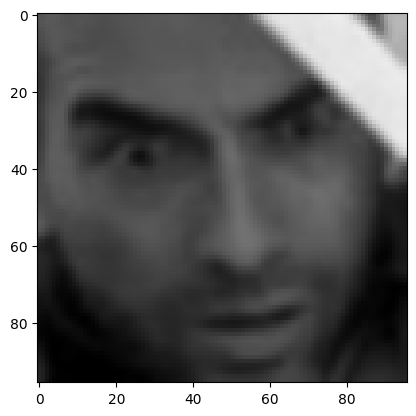

In [20]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

##BUILDING EFFECIENTNET MODEL

In [21]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31790344/31790344 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 3, 3, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                       

In [22]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [23]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_paths)//BATCH_SIZE,
    epochs=8,
    validation_data=val_dataset,
    validation_steps = len(val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 [==============================] - 206s 183ms/step - loss: 2.8108 - accuracy: 0.3959 - precision: 0.6689 - recall: 0.1865 - val_loss: 1.6558 - val_accuracy: 0.4196 - val_precision: 0.5775 - val_recall: 0.2584
Epoch 2/8
672/672 [==============================] - 93s 139ms/step - loss: 2.4150 - accuracy: 0.4881 - precision: 0.6883 - recall: 0.2819 - val_loss: 1.4959 - val_accuracy: 0.4538 - val_precision: 0.6608 - val_recall: 0.2832
Epoch 3/8
672/672 [==============================] - 90s 134ms/step - loss: 2.2371 - accuracy: 0.5181 - precision: 0.6960 - recall: 0.3252 - val_loss: 1.2666 - val_accuracy: 0.5212 - val_precision: 0.6969 - val_recall: 0.3468
Epoch 4/8
672/672 [==============================] - 94s 140ms/step - loss: 2.1244 - accuracy: 0.5430 - precision: 0.7102 - recall: 0.3541 - val_loss: 1.2204 - val_accuracy: 0.5371 - val_precision: 0.7035 - val_recall: 0.3627
Epoch 5/8
672/672 [==============================] - 89s 132ms/step - loss: 2.0419 - accuracy: 

In [24]:
model.layers[0].trainable = False

In [25]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 3, 3, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7949824 (30.33 MB)
Trainable params: 181

In [28]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_paths)//BATCH_SIZE,
    epochs=6,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/6
672/672 [==============================] - ETA: 0s - loss: 1.8417 - accuracy: 0.5934 - precision: 0.7289 - recall: 0.4351
Epoch 1: val_loss improved from inf to 1.16667, saving model to best_weights.h5
672/672 [==============================] - 93s 137ms/step - loss: 1.8417 - accuracy: 0.5934 - precision: 0.7289 - recall: 0.4351 - val_loss: 1.1667 - val_accuracy: 0.5681 - val_precision: 0.6848 - val_recall: 0.4450
Epoch 2/6
672/672 [==============================] - ETA: 0s - loss: 1.7818 - accuracy: 0.6023 - precision: 0.7298 - recall: 0.4516
Epoch 2: val_loss improved from 1.16667 to 1.11336, saving model to best_weights.h5
672/672 [==============================] - 93s 138ms/step - loss: 1.7818 - accuracy: 0.6023 - precision: 0.7298 - recall: 0.4516 - val_loss: 1.1134 - val_accuracy: 0.5734 - val_precision: 0.7098 - val_recall: 0.4227
Epoch 3/6
672/672 [==============================] - ETA: 0s - loss: 1.7501 - accuracy: 0.6164 - precision: 0.7484 - recall: 0.4673
Epoch 3:

##TESTING PHASE

In [30]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [31]:
model.load_weights("best_weights.h5")

In [32]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [33]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


angry


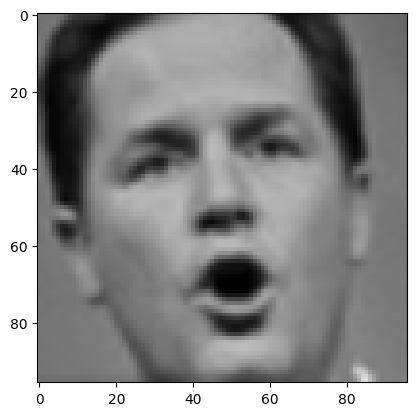

In [34]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [35]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 12s 34ms/step - loss: 1.0723 - accuracy: 0.6069 - precision: 0.6945 - recall: 0.5153
 Testing Acc :  0.606854259967804
 Testing Precision  0.6945174336433411
 Testing Recall  0.515324592590332
